In [1]:
# Author: Md Farhan Tasnim Oshim

import os, glob, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy.signal import decimate
import matplotlib.pyplot as plt
import joblib

In [ ]:
# ----------------------
# CONFIG
# ----------------------
DATA_DIR = "Data"
TARGET_COLUMNS = ["bp", "breath_upper", "ppg_fing"]
TARGET_FS = 30
WINDOW_SEC = 8
WINDOW_SIZE = TARGET_FS * WINDOW_SEC
WINDOW_STRIDE = WINDOW_SIZE // 2
BATCH_SIZE = 64
EPOCHS = 80
LR = 1e-3
WEIGHT_DECAY = 1e-5
PATIENCE = 3 # used for Early Stopping
NOISE_STD = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_DIR = "outputs_mask"
os.makedirs(OUT_DIR, exist_ok=True)
SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

In [3]:
# ----------------------
# UTILS
# ----------------------
def infer_original_fs(df):
    df_short = df[df['time'] <= 1.0]
    return len(df_short)


def is_corrupted(sig, tol=1e-8):
    sig = sig.astype(np.float32)
    if np.all(np.isnan(sig)):
        return True
    if np.std(sig) < tol:
        return True
    return False


def load_and_downsample(file_path):
    df = pd.read_csv(file_path)
    missing = [c for c in TARGET_COLUMNS + ['time'] if c not in df.columns]
    if missing:
        raise ValueError(f"{os.path.basename(file_path)} missing columns: {missing}")
    
    orig_fs = infer_original_fs(df)
    factor = max(1, orig_fs // TARGET_FS)
    target_len = len(df) // factor

    df_down = pd.DataFrame()
    modality_mask = {}
    for col in TARGET_COLUMNS:
        sig = df[col].values.astype(np.float32)
        if is_corrupted(sig):
            print(f"[Warning] {file_path}: corrupted {col}, replacing with zeros")
            sig_down = np.zeros(target_len, dtype=np.float32)
            modality_mask[col] = 0
        else:
            sig_down = decimate(sig, factor, ftype='fir', zero_phase=True).astype(np.float32)
            # force exact length
            if len(sig_down) < target_len:
                sig_down = np.pad(sig_down, (0, target_len - len(sig_down)))
            elif len(sig_down) > target_len:
                sig_down = sig_down[:target_len]
            modality_mask[col] = 1
        df_down[col] = sig_down

    return df_down, modality_mask

def windows_from_df(df, window, stride):
    X = df[TARGET_COLUMNS].values
    N, C = X.shape
    if N < window:
        return np.empty((0, window, C), dtype=np.float32)
    starts = np.arange(0, N - window + 1, stride)
    arr = np.stack([X[s:s+window] for s in starts], axis=0)
    return arr.astype(np.float32)

def load_dataset(file_list, window=WINDOW_SIZE, stride=WINDOW_STRIDE):
    all_wins, all_masks = [], []
    for fp in file_list:
        df_down, mask = load_and_downsample(fp)
        w = windows_from_df(df_down, window, stride)
        if w.size > 0:
            all_wins.append(w)
            m = np.array([list(mask.values())] * w.shape[0], dtype=np.float32)
            all_masks.append(m)
    if not all_wins:
        return (np.empty((0, window, len(TARGET_COLUMNS)), dtype=np.float32),
                np.empty((0, len(TARGET_COLUMNS)), dtype=np.float32))
    return np.concatenate(all_wins, axis=0), np.concatenate(all_masks, axis=0)

def fit_scale_transform_per_mod(train, val, test, train_m, val_m, test_m):
    Ntr, T, C = train.shape
    scalers = []
    train_s = np.zeros_like(train)
    val_s = np.zeros_like(val)
    test_s = np.zeros_like(test)

    for c in range(C):
        scaler = StandardScaler()
        Xtr = train[train_m[:,c]==1, :, c].reshape(-1,1)
        if Xtr.size > 0:
            scaler.fit(Xtr)
        else:
            scaler.mean_, scaler.scale_ = 0.0, 1.0
        scalers.append(scaler)

        def tf(arr, mask):
            out = np.zeros_like(arr[:,:,c])
            for i in range(arr.shape[0]):
                if mask[i,c] == 1:
                    out[i,:] = scaler.transform(arr[i,:,c].reshape(-1,1)).reshape(-1)
                else:
                    out[i,:] = 0.0
            return out

        train_s[:,:,c] = tf(train, train_m)
        val_s[:,:,c] = tf(val, val_m)
        test_s[:,:,c] = tf(test, test_m)

    return train_s, val_s, test_s, scalers

In [ ]:
# ----------------------
# FILE SPLIT & LOAD
# ----------------------
all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))

# Making sure the corrupt files is not in val or test set
def check_file_corruption(file_path, target_columns=TARGET_COLUMNS):
    df = pd.read_csv(file_path)
    for col in target_columns:
        sig = df[col].values.astype(np.float32)
        if is_corrupted(sig):
            print(f"[Warning] {os.path.basename(file_path)} corrupted data in column: {col}")
            return True
    return False


all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))

uncorrupted_files = [f for f in all_files if not check_file_corruption(f)]

val_files = [uncorrupted_files[-2]]
test_files = [uncorrupted_files[-1]]

train_files = [f for f in uncorrupted_files if f not in val_files + test_files]

print("Val_file: ",val_files)
print("test_file: ",test_files)
# ---------------------------------------------------------------------------


train_data, train_mask = load_dataset(train_files)
val_data, val_mask = load_dataset(val_files)
test_data, test_mask = load_dataset(test_files)

train_s, val_s, test_s, scalers = fit_scale_transform_per_mod(
    train_data, val_data, test_data,
    train_mask, val_mask, test_mask
)
joblib.dump(scalers, os.path.join(OUT_DIR, "scalers.pkl"))

In [5]:
# ----------------------
# DATASET WITH MASK
# ----------------------
class WindowDataset(Dataset):
    def __init__(self, arr, masks):
        self.x = torch.from_numpy(arr.transpose(0,2,1)).float()
        self.m = torch.from_numpy(masks).float()
    def __len__(self):
        return self.x.size(0)
    def __getitem__(self, idx):
        x = self.x[idx]
        m = self.m[idx]
        return x, x, m

train_loader = DataLoader(WindowDataset(train_s, train_mask), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(WindowDataset(val_s, val_mask), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(WindowDataset(test_s, test_mask), batch_size=BATCH_SIZE, shuffle=False)

In [6]:
# ----------------------
# MODEL
# ----------------------
class ModalityEncoder(nn.Module):
    def __init__(self, in_ch=1, base=32, latent_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, base, 15, padding=7),
            nn.Tanh(),
            nn.MaxPool1d(2),
            nn.Conv1d(base, base*2, 7, padding=3),
            nn.Tanh()
        )
        self.latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base*2 * (WINDOW_SIZE//2), latent_dim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.latent(self.net(x))

class MultiModalAutoencoderSeparateDecoders(nn.Module):
    def __init__(self, latent_dim=64, fused_latent=128, base=32, out_ch=3):
        super().__init__()
        self.encoders = nn.ModuleList([ModalityEncoder(1, base, latent_dim) for _ in range(out_ch)])
        self.fuse = nn.Sequential(
            nn.Linear(latent_dim*out_ch, fused_latent),
            nn.Tanh(),
            nn.Dropout(0.5) #<-----
        )
        self.decoders = nn.ModuleList()
        for _ in range(out_ch):
            self.decoders.append(nn.Sequential(
                nn.Linear(fused_latent, base*2*(WINDOW_SIZE//2)),
                nn.Tanh(),
                nn.Unflatten(1, (base*2, WINDOW_SIZE//2)),
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv1d(base*2, base, 7, padding=3),
                nn.Tanh(),
                nn.Conv1d(base, 1, 1)
            ))
    def forward(self, x):
        z_list = [enc(x[:,i:i+1,:]) for i, enc in enumerate(self.encoders)]
        z = torch.cat(z_list, dim=1)
        z = self.fuse(z)
        outs = [dec(z) for dec in self.decoders]
        return torch.cat(outs, dim=1)

model = MultiModalAutoencoderSeparateDecoders().to(DEVICE)

In [7]:
# -----------------------------------
# TIME DOMAIN WEIGHTED LOSS WITH MASK
# -----------------------------------
def weighted_mse_loss(pred, target, mask, weights=[1.0,2.0,4.0]):
    total = 0.0
    count = 0
    for c, w in enumerate(weights):
        valid = mask[:,c] == 1
        if valid.any():
            total += w * nn.functional.mse_loss(pred[valid, c, :], target[valid, c, :])
            count += 1
    return total / (count if count > 0 else 1)

# ---------------------------------
# SPECTRAL WEIGHTED LOSS WITH MASK
# ---------------------------------
def spectral_loss(pred, target, mask, weights=[1.0, 2.0, 4.0]):
    total = 0.0
    count = 0
    for c, w in enumerate(weights):
        valid = mask[:, c] == 1
        if valid.any():
            pred_c = pred[valid, c, :]
            target_c = target[valid, c, :]
            pred_fft = torch.fft.rfft(pred_c, dim=-1)
            target_fft = torch.fft.rfft(target_c, dim=-1)
            pred_mag = torch.abs(pred_fft)
            target_mag = torch.abs(target_fft)
            pred_mag = pred_mag / (pred_mag.sum(dim=-1, keepdim=True) + 1e-8)
            target_mag = target_mag / (target_mag.sum(dim=-1, keepdim=True) + 1e-8)
            total += w * nn.functional.mse_loss(pred_mag, target_mag)
            count += 1
    return total / (count if count > 0 else 1)

# -----------------------------------
# TOTAL LOSS
# -----------------------------------
def total_loss(pred, target, mask, alpha=1.0, beta=0.5, weights=[1.0,2.0,4.0]):
    loss_time = weighted_mse_loss(pred, target, mask, weights)
    loss_freq = spectral_loss(pred, target, mask, weights)
    return alpha * loss_time + beta * loss_freq, loss_time, loss_freq

Epoch 001 | Train 0.955449 (Time 1.909476, Freq 0.001421) | Val 1.362169 (Time 2.723195, Freq 0.001144)
Epoch 002 | Train 0.658345 (Time 1.315743, Freq 0.000947) | Val 1.066669 (Time 2.132339, Freq 0.000999)
Epoch 003 | Train 0.569005 (Time 1.137122, Freq 0.000888) | Val 0.937768 (Time 1.874563, Freq 0.000974)
Epoch 004 | Train 0.517606 (Time 1.034357, Freq 0.000854) | Val 0.861555 (Time 1.722189, Freq 0.000921)
Epoch 005 | Train 0.472789 (Time 0.944737, Freq 0.000841) | Val 0.838677 (Time 1.676518, Freq 0.000835)
Epoch 006 | Train 0.465181 (Time 0.929517, Freq 0.000846) | Val 0.881246 (Time 1.761752, Freq 0.000740)
Epoch 007 | Train 0.454694 (Time 0.908662, Freq 0.000726) | Val 0.822437 (Time 1.643974, Freq 0.000900)
Epoch 008 | Train 0.434858 (Time 0.868973, Freq 0.000743) | Val 0.780545 (Time 1.560359, Freq 0.000731)
Epoch 009 | Train 0.420702 (Time 0.840720, Freq 0.000684) | Val 0.753270 (Time 1.505864, Freq 0.000675)
Epoch 010 | Train 0.413450 (Time 0.826232, Freq 0.000669) | Val 

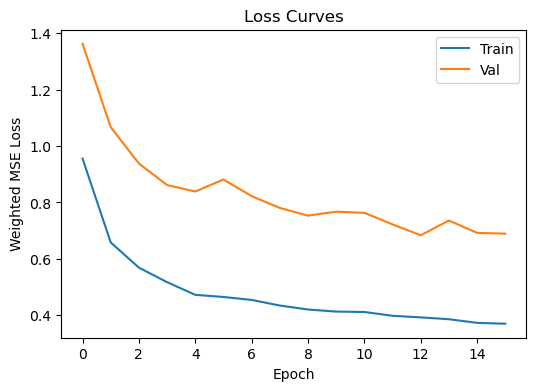

In [8]:
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# ----------------------
# TRAINING / VALIDATION
# ----------------------
best_val = float('inf')
patience_counter = 0
train_losses, val_losses = [], []
noise_std = torch.empty(1).uniform_(0.01, 0.1).item()  # random sigma


for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    train_epoch_loss, train_loss_time, train_loss_freq = 0.0, 0.0, 0.0
    for xb, yb, mask in train_loader:
        xb, yb, mask = xb.to(DEVICE), yb.to(DEVICE), mask.to(DEVICE)
        
        

    #  Noise injected dynamically here:
        noise = torch.randn_like(xb) * noise_std
        xb = xb + noise

        optimizer.zero_grad()
        pred = model(xb)


        loss, lt, lf = total_loss(pred, yb, mask, alpha=0.5, beta=0.5)
        loss.backward()
        optimizer.step()

        # accumulate
        train_epoch_loss += loss.item() * xb.size(0)
        train_loss_time += lt.item() * xb.size(0)
        train_loss_freq += lf.item() * xb.size(0)

    # average over dataset
    train_epoch_loss /= len(train_loader.dataset)
    train_loss_time  /= len(train_loader.dataset)
    train_loss_freq  /= len(train_loader.dataset)
    train_losses.append(train_epoch_loss)

    # ---- VALIDATION ----
    model.eval()
    val_epoch_loss, val_loss_time, val_loss_freq = 0.0, 0.0, 0.0
    with torch.no_grad():
        for xb, yb, mask in val_loader:
            xb, yb, mask = xb.to(DEVICE), yb.to(DEVICE), mask.to(DEVICE)
            pred = model(xb)
            loss, lt, lf = total_loss(pred, yb, mask, alpha=0.5, beta=0.5)
            val_epoch_loss += loss.item() * xb.size(0)
            val_loss_time += lt.item() * xb.size(0)
            val_loss_freq += lf.item() * xb.size(0)

    # average
    val_epoch_loss /= len(val_loader.dataset)
    val_loss_time  /= len(val_loader.dataset)
    val_loss_freq  /= len(val_loader.dataset)
    val_losses.append(val_epoch_loss)

    # ---- PRINT ----
    print(f"Epoch {epoch+1:03d} | "
          f"Train {train_epoch_loss:.6f} (Time {train_loss_time:.6f}, Freq {train_loss_freq:.6f}) | "
          f"Val {val_epoch_loss:.6f} (Time {val_loss_time:.6f}, Freq {val_loss_freq:.6f})")


    # ---- EARLY STOPPING ----
    if val_epoch_loss < best_val:
        best_val = val_epoch_loss
        torch.save(model.state_dict(), os.path.join(OUT_DIR, "best_model.pth"))
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# ----------------------
# TEST EVALUATION
# ----------------------
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_model.pth")))
model.eval()
test_epoch_loss = 0.0
with torch.no_grad():
    for xb, yb, mask in test_loader:
        xb, yb, mask = xb.to(DEVICE), yb.to(DEVICE), mask.to(DEVICE)
        loss, _, _ = total_loss(model(xb), yb, mask, alpha=0.5, beta=0.5)
        test_epoch_loss += loss.item() * xb.size(0)
test_epoch_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_epoch_loss:.6f}")

# ----------------------
# LOSS CURVES
# ----------------------
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Weighted MSE Loss")
plt.title("Loss Curves")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "loss_curves.png"))
plt.show()


In [9]:

# ----------------------
# INVERSE TRANSFORM
# ----------------------
scalers = joblib.load(os.path.join(OUT_DIR, "scalers.pkl"))

def inverse_transform_reconstruction(pred_scaled):
    N, C, T = pred_scaled.shape
    pred_orig = np.empty_like(pred_scaled)
    for c in range(C):
        pred_orig[:,c,:] = scalers[c].inverse_transform(pred_scaled[:,c,:].reshape(-1,1)).reshape(N,T)
    return pred_orig

def inverse_transform_original(arr_scaled):
    N, C, T = arr_scaled.shape
    arr_orig = np.empty_like(arr_scaled)
    for c in range(C):
        arr_orig[:,c,:] = scalers[c].inverse_transform(arr_scaled[:,c,:].reshape(-1,1)).reshape(N,T)
    return arr_orig


In [10]:
# ----------------------
# VISUALIZATION (Time + Frequency)
# ----------------------
def visualize_reconstruction(model, dataset, n=3, fs=TARGET_FS):
    model.eval()
    xb, _, _ = next(iter(DataLoader(dataset, batch_size=n, shuffle=True)))
    xb = xb.to(DEVICE)
    with torch.no_grad():
        pred_scaled = model(xb).cpu().numpy()
    xb_scaled = xb.cpu().numpy()
    
    # Inverse scale
    pred_orig_temp = inverse_transform_reconstruction(pred_scaled)
    xb_orig_temp = inverse_transform_original(xb_scaled)

    # mean Subtraction

    pred_orig = pred_orig_temp - np.mean(pred_orig_temp, axis=2, keepdims=True)
    xb_orig = xb_orig_temp - np.mean(xb_orig_temp, axis=2, keepdims=True)

    # print(pred_orig_temp.shape)

    for i in range(n):
        plt.figure(figsize=(14, 6))
        for c, col in enumerate(TARGET_COLUMNS):
            # --- Time Domain ---
            plt.subplot(2, len(TARGET_COLUMNS), c+1)
            plt.plot(xb_orig[i,c,:], label="Original", alpha=0.8)
            plt.plot(pred_orig[i,c,:], label="Reconstruction", alpha=0.8)
            plt.title(f"{col} (Time Domain)")
            plt.legend()

            # --- Frequency Domain ---
            orig_fft = np.abs(np.fft.rfft(xb_orig[i,c,:]))
            pred_fft = np.abs(np.fft.rfft(pred_orig[i,c,:]))
            freqs = np.fft.rfftfreq(xb_orig.shape[-1], d=1/fs)

            plt.subplot(2, len(TARGET_COLUMNS), len(TARGET_COLUMNS)+c+1)
            plt.plot(freqs, orig_fft, label="Original", alpha=0.8)
            plt.plot(freqs, pred_fft, label="Reconstruction", alpha=0.8)
            plt.title(f"{col} (Frequency Domain)")
            plt.xlabel("Frequency [Hz]")
            plt.legend()

        plt.tight_layout()
        plt.show()



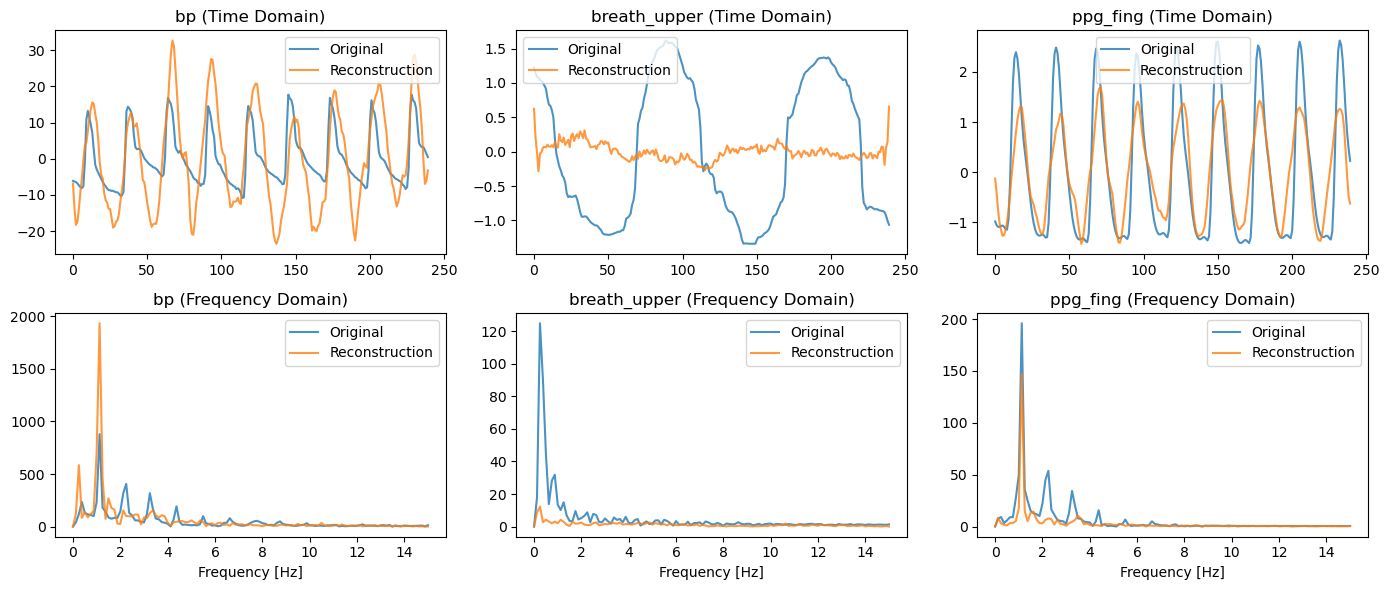

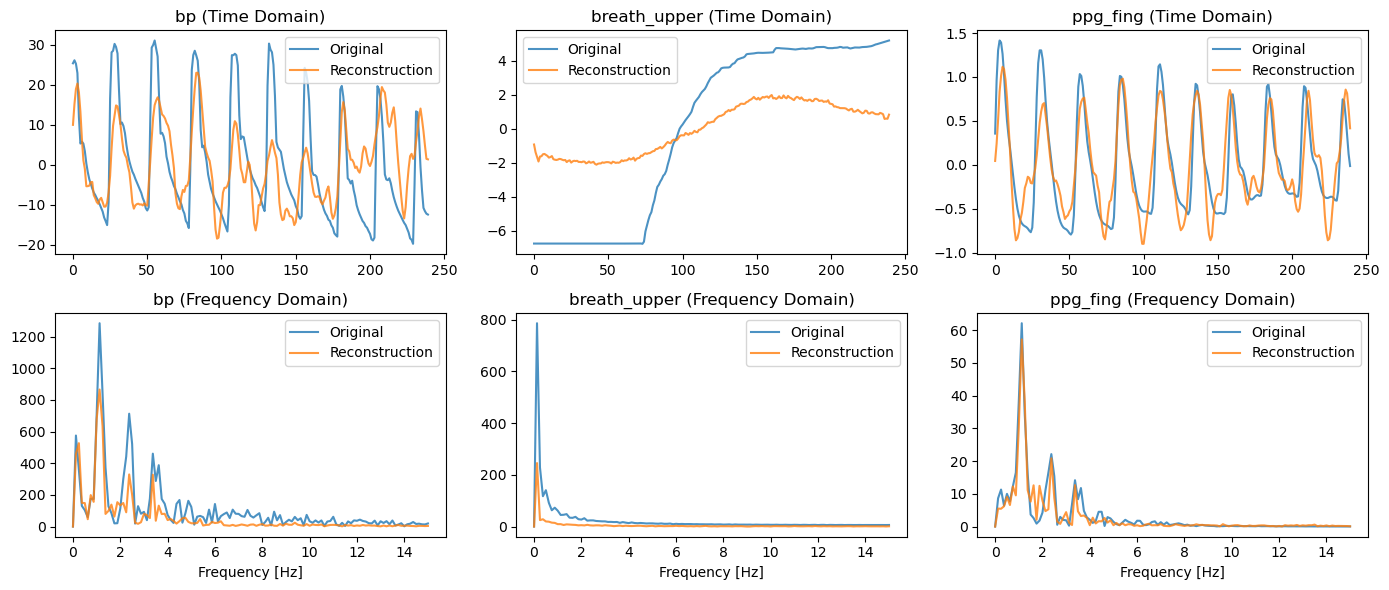

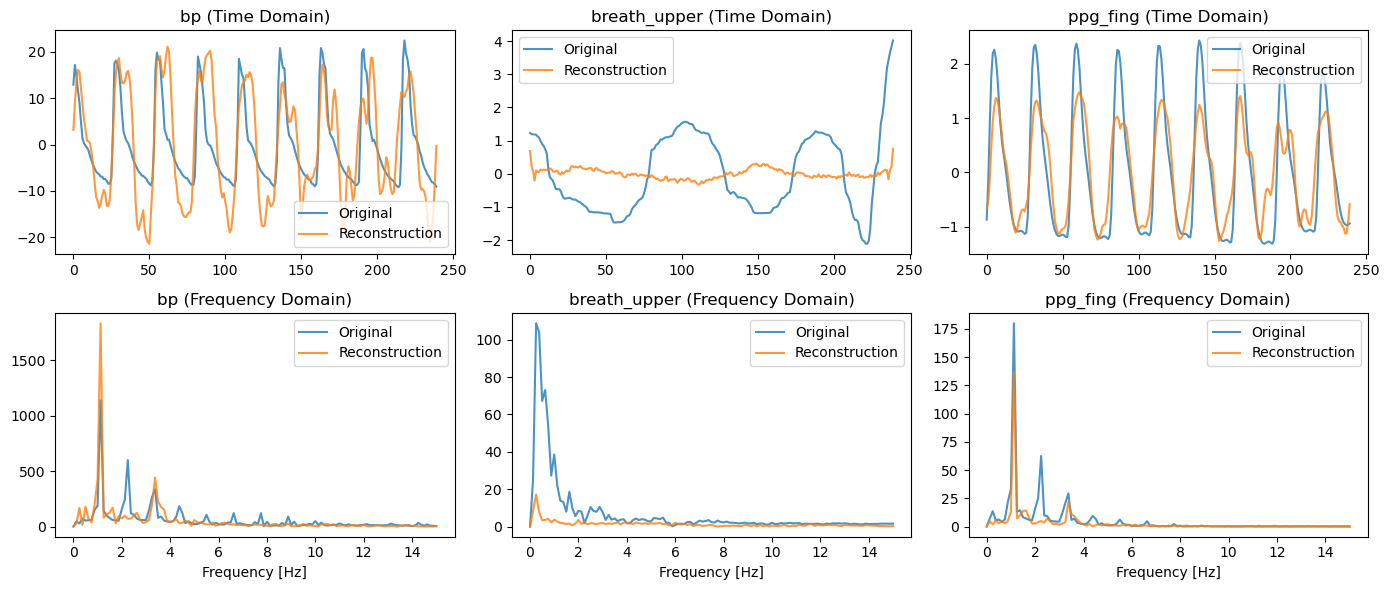

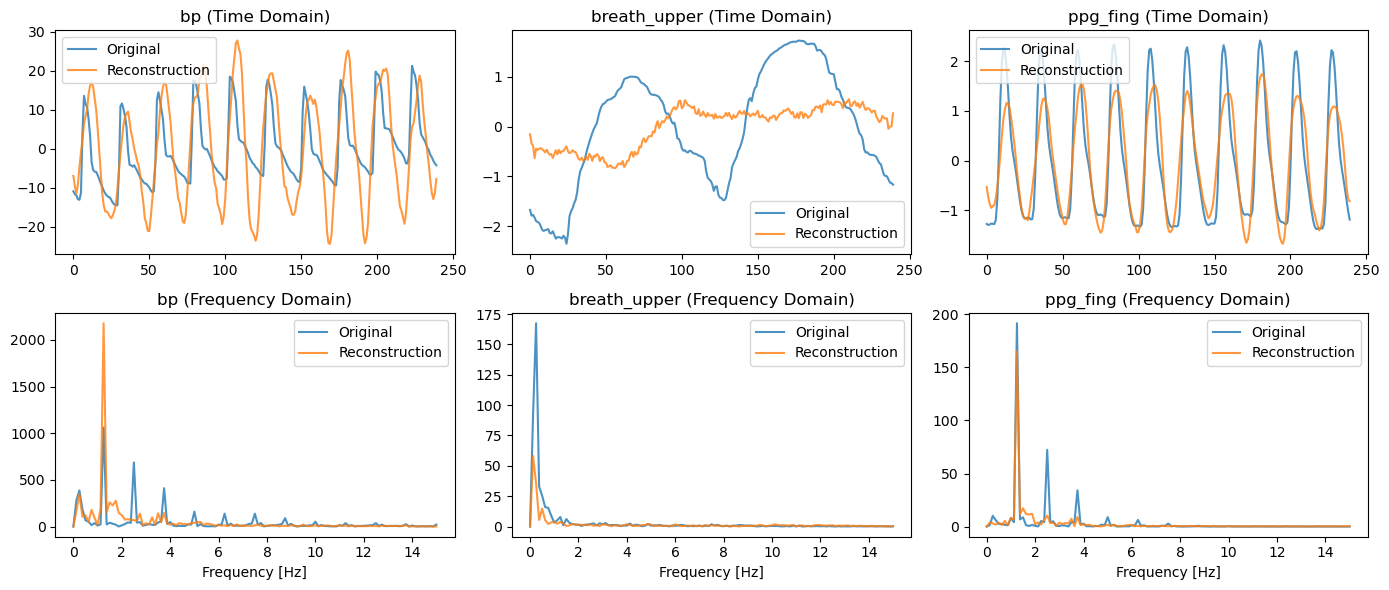

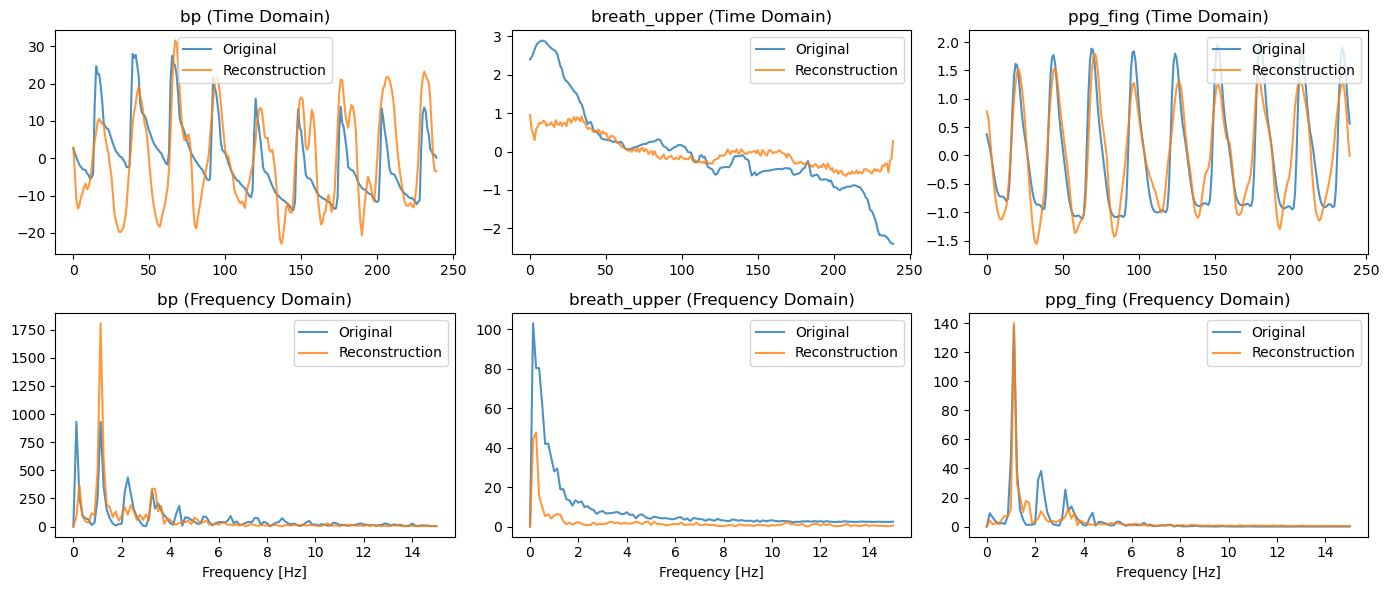

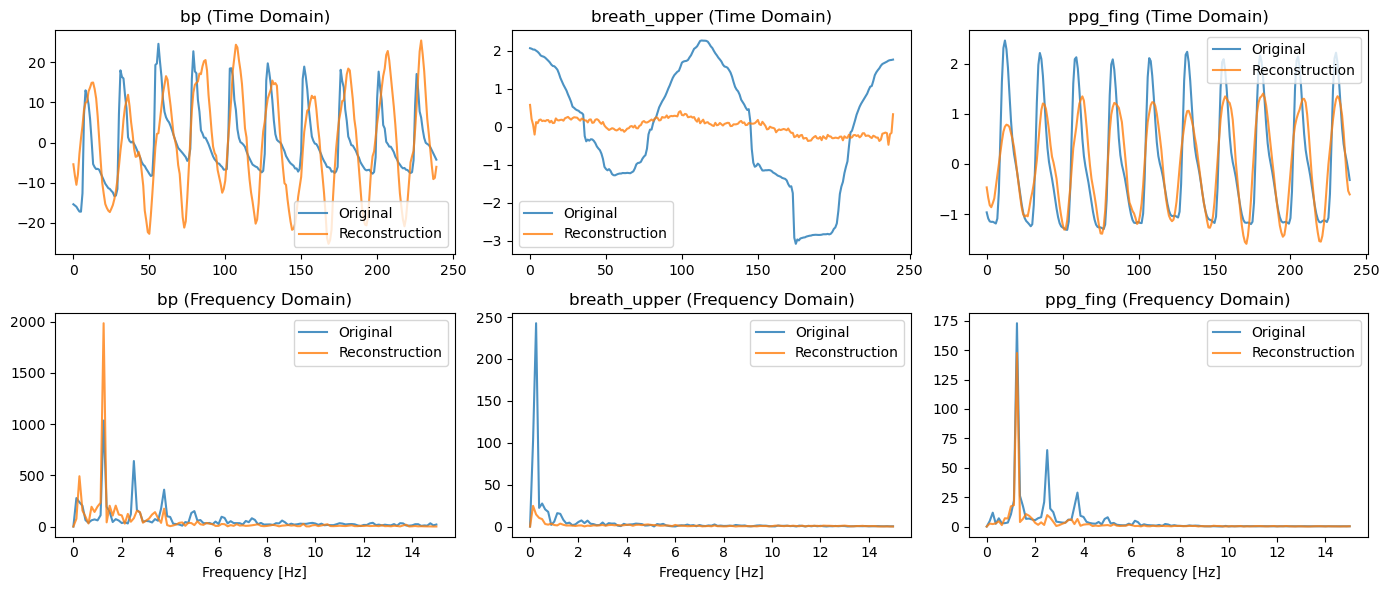

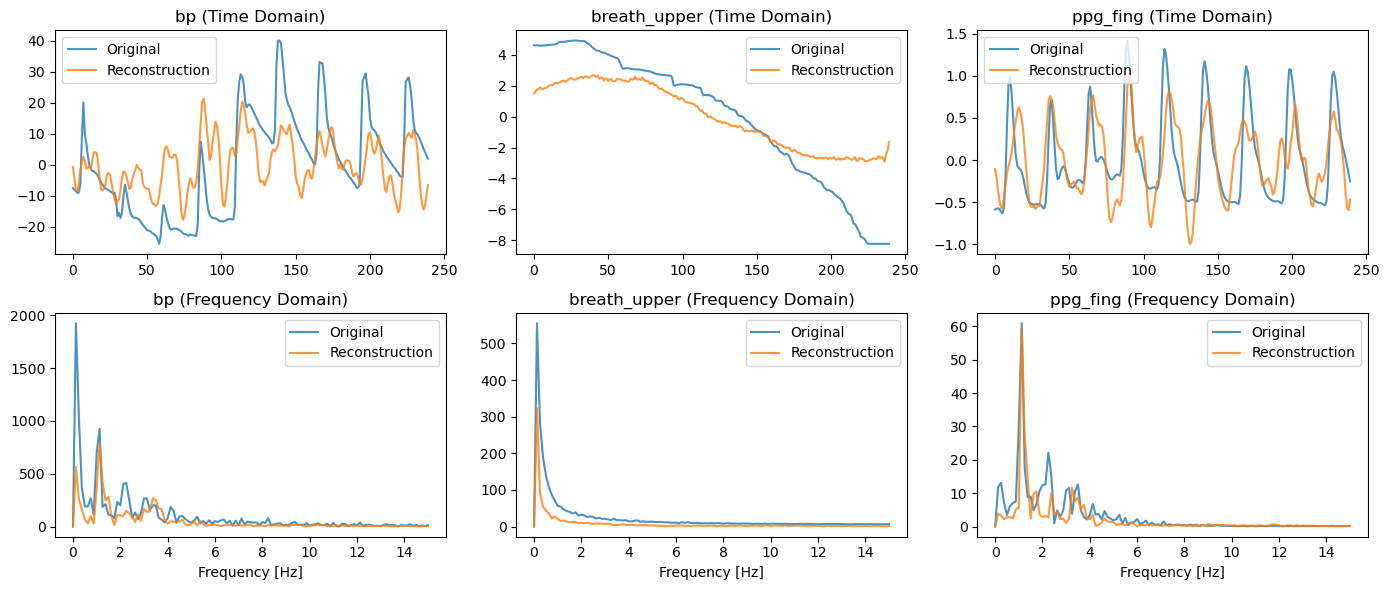

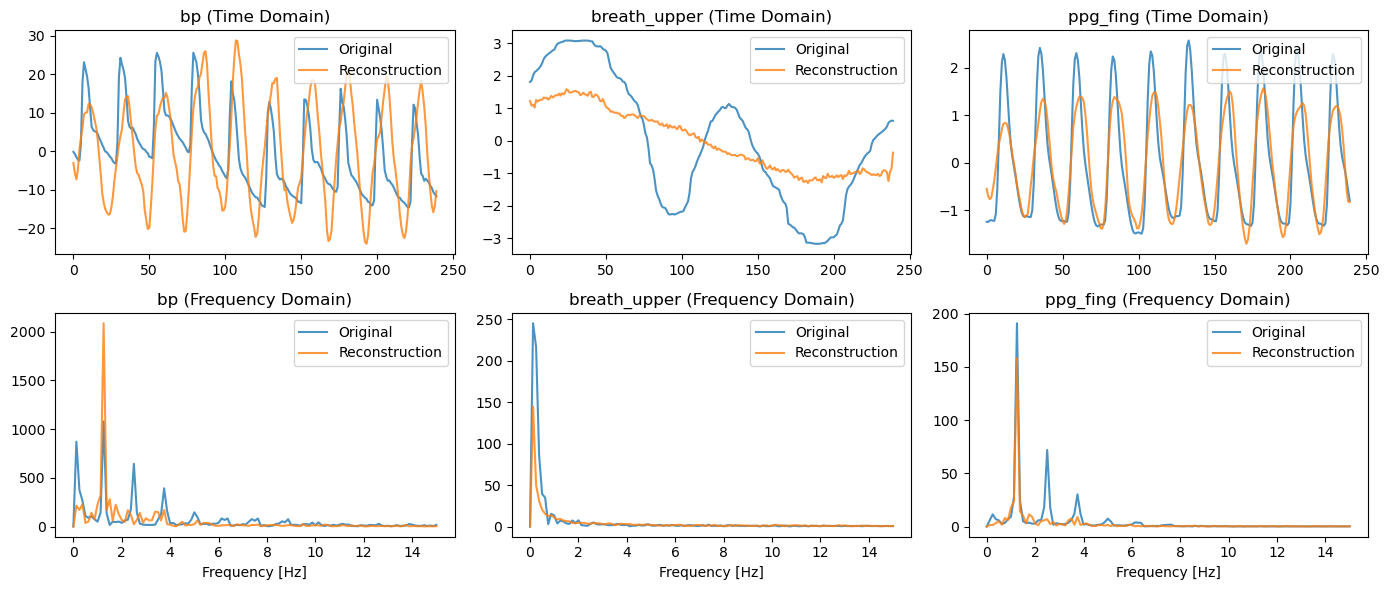

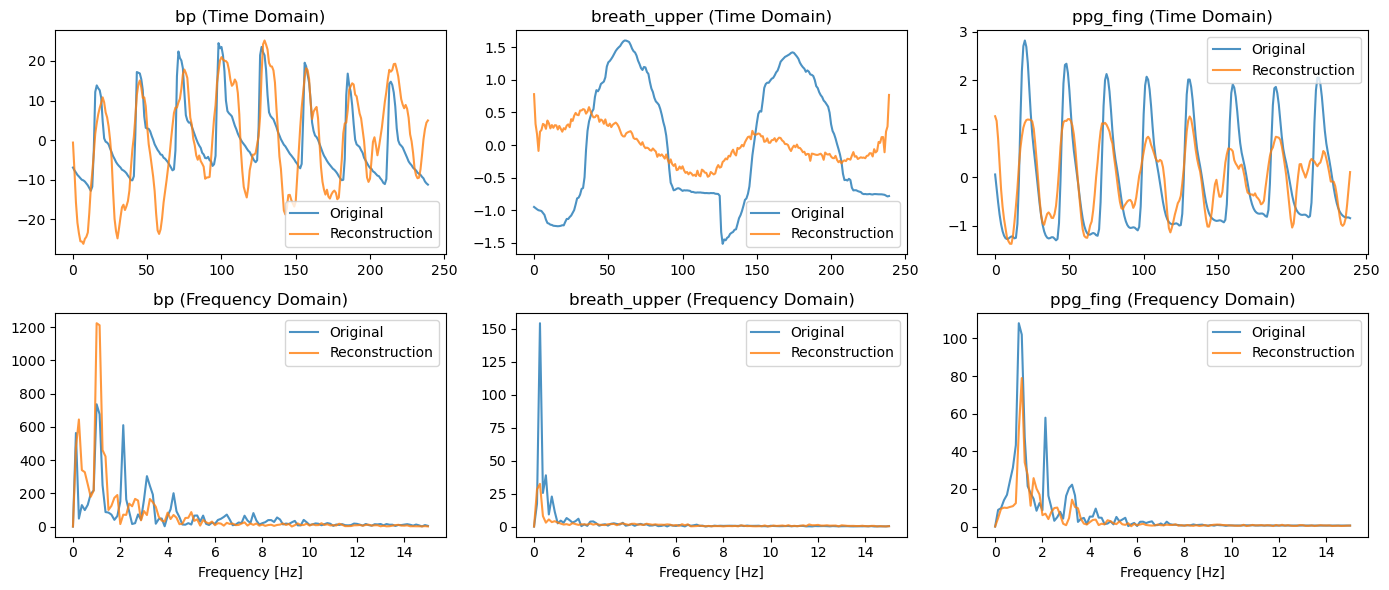

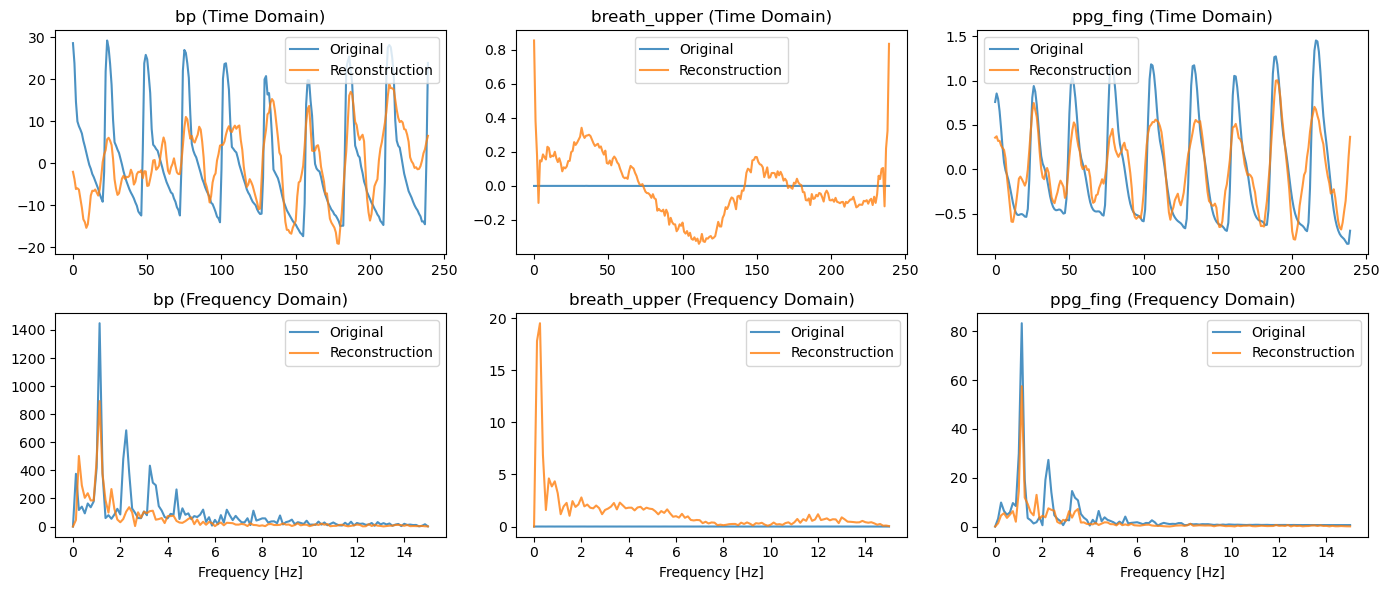

In [11]:
visualize_reconstruction(model, test_loader.dataset, n=10)

In [ ]:
# ====== EVALUATION: Compression, Denoising, Cross-Modal ======
import torch.nn.functional as F

# --- helpers ---
def _to_numpy(x):
    return x.detach().cpu().numpy()

def _snr_db(clean, estimate):
    # clean, estimate: (B, T)
    noise = clean - estimate
    num = np.sum(clean**2, axis=-1) + 1e-12
    den = np.sum(noise**2, axis=-1) + 1e-12
    return 10.0 * np.log10(num / den)

def _mae_mse(clean, estimate):
    mae = np.mean(np.abs(clean - estimate))
    mse = np.mean((clean - estimate)**2)
    return mae, mse

def _spec_mag_norm(x):
    # x: (B, T) -> rfft mag normalized per sample
    X = np.fft.rfft(x, axis=-1)
    mag = np.abs(X)
    mag = mag / (np.sum(mag, axis=-1, keepdims=True) + 1e-12)
    return mag

def _spec_cosine(a, b):
    # a,b: (B, F)
    num = np.sum(a * b, axis=-1)
    den = (np.linalg.norm(a, axis=-1) * np.linalg.norm(b, axis=-1) + 1e-12)
    return num / den

def _inverse_batch(arr_scaled, scalers):
    # arr_scaled: (B, C, T)
    B, C, T = arr_scaled.shape
    out = np.empty_like(arr_scaled)
    for c in range(C):
        out[:, c, :] = scalers[c].inverse_transform(arr_scaled[:, c, :].reshape(-1, 1)).reshape(B, T)
    return out

# use original scale for interpretability
try:
    scalers  # already loaded above in your script
except NameError:
    scalers = joblib.load(os.path.join(OUT_DIR, "scalers.pkl"))

# ---------- 1) Feature Compression ----------
def evaluate_compression(model, input_len=WINDOW_SIZE, num_modalities=len(TARGET_COLUMNS)):
    input_size = num_modalities * input_len

    model.eval()
    with torch.no_grad():
        # make a tiny dummy batch to read shapes
        xb, _, _ = next(iter(test_loader))
        xb = xb.to(DEVICE)

        z_list = [enc(xb[:, i:i+1, :]) for i, enc in enumerate(model.encoders)]
        z = torch.cat(z_list, dim=1)
        z_fused = model.fuse(z)  
        fused_latent = z_fused.shape[1]
    compression_ratio = input_size / fused_latent
    return {
        "input_size_floats": int(input_size),
        "bottleneck_size_floats": int(fused_latent),
        "compression_ratio": float(compression_ratio),
    }

# ---------- 2) Denoising (noisy -> reconstruct -> compare to clean) ----------
def evaluate_denoising(model, loader, noise_std=0.05):
    model.eval()
    per_mod_results = {c: {"SNR_dB_gain": [], "MAE": [], "MSE": [], "SpecCos": []}
                       for c in range(len(TARGET_COLUMNS))}
    with torch.no_grad():
        for xb, yb, _ in loader:
            xb = xb.to(DEVICE)       # (B, C, T) standardized
            yb = yb.to(DEVICE)

            # make a noisy input
            noise = noise_std * torch.randn_like(xb)
            xb_noisy = xb + noise

            pred = model(xb_noisy)   # reconstruct
            # to numpy (standardized)
            clean = _to_numpy(yb)           # (B, C, T)
            recon = _to_numpy(pred)
            noisy = _to_numpy(xb_noisy)

            # to original scale for interpretability
            clean_o = _inverse_batch(clean, scalers)
            recon_o = _inverse_batch(recon, scalers)
            noisy_o = _inverse_batch(noisy, scalers)

            B, C, T = clean.shape
            for c in range(C):
                clean_c = clean_o[:, c, :]
                recon_c = recon_o[:, c, :]
                noisy_c = noisy_o[:, c, :]

                # SNR gain: SNR(recon, clean) - SNR(noisy, clean)
                snr_recon = _snr_db(clean_c, recon_c)
                snr_noisy = _snr_db(clean_c, noisy_c)
                snr_gain = snr_recon - snr_noisy

                mae, mse = _mae_mse(clean_c, recon_c)

                # spectral similarity (cosine of normalized magnitude spectra)
                sm_clean = _spec_mag_norm(clean_c)
                sm_recon = _spec_mag_norm(recon_c)
                spec_cos = _spec_cosine(sm_clean, sm_recon)

                per_mod_results[c]["SNR_dB_gain"].extend(list(snr_gain))
                per_mod_results[c]["MAE"].append(mae)
                per_mod_results[c]["MSE"].append(mse)
                per_mod_results[c]["SpecCos"].extend(list(spec_cos))

    # aggregate
    out = {}
    for c, name in enumerate(TARGET_COLUMNS):
        d = per_mod_results[c]
        out[name] = {
            "ΔSNR_dB_mean": float(np.mean(d["SNR_dB_gain"])),
            "MAE_mean":     float(np.mean(d["MAE"])),
            "MSE_mean":     float(np.mean(d["MSE"])),
            "SpecCos_mean": float(np.mean(d["SpecCos"])),
        }
    return out

# ---------- 3) Cross-modal reconstruction ----------
# Zero one modality at input; reconstruct it from the others; score only that modality.
def evaluate_cross_modal(model, loader):
    model.eval()
    results = {}

    with torch.no_grad():
        # init containers
        acc = {
            c: {"MAE": [], "MSE": [], "SNR_dB": [], "SpecCos": []}
            for c in range(len(TARGET_COLUMNS))
        }

        for xb, yb, _ in loader:
            xb = xb.to(DEVICE)  # standardized
            yb = yb.to(DEVICE)

            B, C, T = xb.shape
            for c in range(C):
                xb_miss = xb.clone()
                xb_miss[:, c, :] = 0.0  # simulate missing modality (standardized mean)

                pred = model(xb_miss)

                # to numpy / original scale
                clean = _to_numpy(yb)        # (B, C, T)
                recon = _to_numpy(pred)

                clean_o = _inverse_batch(clean, scalers)
                recon_o = _inverse_batch(recon, scalers)

                clean_c = clean_o[:, c, :]
                recon_c = recon_o[:, c, :]

                mae, mse = _mae_mse(clean_c, recon_c)
                snr = _snr_db(clean_c, recon_c)

                sm_clean = _spec_mag_norm(clean_c)
                sm_recon = _spec_mag_norm(recon_c)
                spec_cos = _spec_cosine(sm_clean, sm_recon)

                acc[c]["MAE"].append(mae)
                acc[c]["MSE"].append(mse)
                acc[c]["SNR_dB"].extend(list(snr))
                acc[c]["SpecCos"].extend(list(spec_cos))

    for c, name in enumerate(TARGET_COLUMNS):
        d = acc[c]
        results[name] = {
            "CrossModal_MAE":     float(np.mean(d["MAE"])),
            "CrossModal_MSE":     float(np.mean(d["MSE"])),
            "CrossModal_SNR_dB":  float(np.mean(d["SNR_dB"])),
            "CrossModal_SpecCos": float(np.mean(d["SpecCos"])),
        }
    return results

compression_summary = evaluate_compression(model)
denoise_summary      = evaluate_denoising(model, test_loader, noise_std=0.05)  # tune sigma
crossmodal_summary   = evaluate_cross_modal(model, test_loader)


from tabulate import tabulate

# Convert summaries into list of rows
results = []

# Compression
for k,v in compression_summary.items():
    results.append(["Compression", k, v])

# Denoising
for k,v in denoise_summary.items():
    results.append(["Denoising", k, v])

# Cross-Modal
for k,v in crossmodal_summary.items():
    results.append(["Cross-Modal", k, v])

# Print nice table
print(tabulate(results, headers=["Task", "Metric", "Value"], tablefmt="pretty"))





+-------------+------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    Task     |         Metric         |                                                                             Value                                                                              |
+-------------+------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Compression |   input_size_floats    |                                                                              720                                                                               |
| Compression | bottleneck_size_floats |                                                                              128                                                                       